## Building Classifiers to filter Spam Emails

- Naive Bayes
- Decision Tree
- Nearest Neighbor

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Doyeon/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['text', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import numpy as np
import pylab as plt
import nltk
import glob

## word stemming
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
ps = PorterStemmer()
#nltk.download()

### Load Spam and Ham (Non-Spam) emails

In [3]:
ham_address = '/Volumes/Extra/Columbia/Fall2018/Classes/ML/enron1/ham/'
spam_address = '/Volumes/Extra/Columbia/Fall2018/Classes/ML/enron1/spam/'

In [4]:
summary_file = open('/Volumes/Extra/Columbia/Fall2018/Classes/ML/enron1/Summary.txt')
summary = summary_file.read()
summary_file.close()

In [4]:
hams = []
hamfiles = sorted(glob.glob(ham_address+'*.txt'))
hfiles = len(hamfiles)
for i in range(hfiles):
    file = open(hamfiles[i], 'rt')
    text = file.read()
    hams.append(text)
    file.close()

spams = []
spamfiles = sorted(glob.glob(spam_address+'*.txt'))
sfiles = len(spamfiles)
for i in range(sfiles):
    file = open(spamfiles[i], 'rt', encoding="latin-1")
    text = file.read()
    spams.append(text)
    file.close()

### Form dictionary using Stemming and Bag-of-Word Model

In [12]:
def embed_one(datalist):
    """
    Construct stemmed+bag-of-words model for individual then construct an array of individual bags
    
    Returns
    a collection of individual set dict corresponding to its counts
    A list of N_items of individual dictionary
    """
    bag_collection = []
    ndata = len(datalist)
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    for i in range(ndata):
        stemmed = []
        token = tokenizer.tokenize(datalist[i])
        for w in token:
            stemmed.append(ps.stem(w))
    
        nstem = len(stemmed)
        one_bag = {}
        
        for j in range(nstem):
            key = stemmed[j]
            if key in one_bag:
                one_bag[key] += 1
            else:
                one_bag[key] = 1
        bag_collection.append(one_bag)
        
    return bag_collection

def embed_whole(datalist):
    """
    From a list of data (should have multiple), do stemming (+remove non-words) then apply the bag-of-words model
    
    Returns
    A combined dictionary of whole data
    """
    bag = {}
    ndata = len(datalist)
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    for i in range(ndata):
        stemmed = []
        token = tokenizer.tokenize(datalist[i])
        for w in token:
            stemmed.append(ps.stem(w))
        #stemmed = list(set(stemmed))
        nstem = len(stemmed)
        for j in range(nstem):
            key = stemmed[j]
            if key in bag:
                bag[key] += 1
            else:
                bag[key] = 1        
    return bag
    
def embed_one_sample(onelist):
    """
    Construct a dictionary for one email
    """
    one_bag = {}
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    token = tokenizer.tokenize(onelist)
    stemmed = []
    one_bag = {}
    for w in token:
        stemmed.append(ps.stem(w))
    nstem = len(stemmed)
    for j in range(nstem):
        key = stemmed[j]
        if key in one_bag:
            one_bag[key] += 1
        else:
            one_bag[key] = 1
    
    return one_bag

def overlap(dict1, dict2):
    """
    Find the overlapping dictionaries
    """
    key1 = set(dict1.keys())
    key2 = set(dict2.keys())
    intersection = key1 & key2
    newdict1 = {}
    newdict2 = {}
    intersection = list(intersection)
    ninter = len(intersection)
    for i in range(ninter):
        newdict1[intersection[i]] = dict1[intersection[i]]
        newdict2[intersection[i]] = dict2[intersection[i]]
    return newdict1, newdict2
    

In [13]:
ham_one_bag = embed_one(hams)
spam_one_bag = embed_one(spams)

In [14]:
whole = np.concatenate((hams, spams))
whole_bag = embed_whole(whole)
whole_one_bag = embed_one(whole)

In [15]:
spam_sum_bag = embed_whole(spams)
ham_sum_bag = embed_whole(hams)

In [28]:
ovlp_spam, ovlp_ham = overlap(spam_sum_bag, ham_sum_bag)

### Accessories

In [20]:
def key_differences(dict1, dict2, len1, len2):
    """
    Evaluate differences 
    """
    dict1_key = dict1.keys()
    dict2_key = dict2.keys()
    dict1_only = list(set(dict1_key)-set(dict2_key))
    dict2_only = list(set(dict2_key)-set(dict1_key))
    
    allkeys = list(dict1_key|dict2_key)
    
    diff_dics = {}
    for i in range(len(allkeys)):
        if allkeys[i] in dict1_only:
            diff_dics[allkeys[i]] = dict1[allkeys[i]] / len1
        elif allkeys[i] in dict2_only:
            diff_dics[allkeys[i]] = dict2[allkeys[i]] / len2
        else:
            diff_dics[allkeys[i]] = np.abs(dict1[allkeys[i]] / len1 -  dict2[allkeys[i]] / len2)
    
    diff_dics = sorting_hand(diff_dics)
    return diff_dics

def sorting_hand(dic, sort='descending'):
    """
    Input a dictionary and sort based on N_items
    """
    if sort == 'descending':
        sorted_dic = sorted(dic.items(), key=lambda x: x[1], reverse=True)
    elif sort == 'ascending':
        sorted_dic = sorted(dic.items(), key=lambda x: x[1], reverse=False)
    return sorted_dic

def count_keywords(embedded_dict, keyword):
    """
    Count keywords in the "already embedded" dictionary
    Returns:
    count arrays and its median
    """
    ndict = len(embedded_dict)
    count = np.zeros(ndict)
    for i in range(ndict):
        onekeys = embedded_dict[i].keys()
        if keyword in onekeys:
            count[i] = embedded_dict[i][keyword]
        else:
            count[i] = 0
            
    return count, np.median(count)


def spliting_sets(train1, train2, keyword):
    """
    Spliting
    """
    cut_thresh = find_decision_threshold(train1, train2, keyword)
    train1_distr, train1_med = count_keywords(train1, keyword)
    train2_distr, train2_med = count_keywords(train2, keyword)
    
    ntrain1 = len(train1_distr)
    ntrain2 = len(train2_distr)
    
    train1_low = []
    train1_high = []
    train2_low = []
    train2_high = []
    
    for i in range(ntrain1):
        if train1_distr[i] <= cut_thresh:
            train1_low.append(train1[i])
        else:
            train1_high.append(train1[i])
        
    for j in range(ntrain2):
        if train2_distr[j] <= cut_thresh:
            train2_low.append(train2[j])
        else:
            train2_high.append(train2[j])
    
    return train1_low, train1_high, train2_low, train2_high

### Decision Tree

In [41]:
def find_decision_threshold(train1, train2, keyword):
    """
    Compute the entropy to determine the decision boundary
    """
    train1_distr, train1_med = count_keywords(train1, keyword)
    train2_distr, train2_med = count_keywords(train2, keyword)
    
    maxi = int(np.max(np.concatenate((train1_distr,train2_distr))))
    
    entropies = np.zeros((maxi, 2))
    weighted_entrop = np.zeros(maxi)
    
    if maxi == 0:
        return maxi
    
    for i in range(maxi):
        ntrain1_low = len(np.where(train1_distr <= i)[0])
        ntrain2_low = len(np.where(train2_distr <= i)[0])
        entropies[i,0] = compute_entropy(ntrain1_low, ntrain2_low)
        
        ntrain1_high = len(np.where(train1_distr > i)[0])
        ntrain2_high = len(np.where(train2_distr > i)[0])
        entropies[i,1] = compute_entropy(ntrain1_high, ntrain2_high)
       
        ntrain_low = ntrain1_low + ntrain2_low
        ntrain_high = ntrain1_high + ntrain2_high
        all_ntrain = ntrain_low + ntrain_high
    
        weighted_entrop[i] = ntrain_low / all_ntrain * entropies[i,0] + ntrain_high / all_ntrain * entropies[i,1]
        #print(ntrain1_low, ntrain2_low, ntrain1_high, ntrain2_high)
    
    #print(weighted_entrop)
    #print(np.nanargmin(weighted_entrop))
    return np.nanargmin(weighted_entrop)


def compute_entropy(train1_count, train2_count):
    """
    Compute Entropy to judge whether this is a good classifier for one dictionary
    """
    if train1_count == 0 or train2_count == 0:
        return 0
    
    total_count = train1_count + train2_count
    
    ratio1 = train1_count / total_count
    ratio2 = train2_count / total_count
    entropy = - ratio1 * np.log2(ratio1) - ratio2 * np.log2(ratio2)
    return entropy


class DTnode(object):
    def __init__(self, threshold, major, feature, left, right):
        self.threshold = threshold
        self.feature = feature
        self.left = left
        self.right = right
        self.major = major

        
def Make_DT(train1, train2, featurelist):
    
    return_node = DTnode(threshold=None, major=None, feature=None, left=None, right=None)
    
    if len(train1) > len(train2):
        return_node.major = 0.
    else:
        return_node.major = 1.
    
    if len(featurelist) == 0:
        return_node.threshold = -1
        return return_node
    
    feature = featurelist[0]
    return_node.feature = feature
        
    if len(train1) == 0 or len(train2) == 0:
        return_node.threshold = -1
        return return_node

    thresh = find_decision_threshold(train1, train2, feature)
    return_node.threshold = thresh
    
    low1, high1, low2, high2 = spliting_sets(train1, train2, feature)
    
    featurelist = featurelist[1:]
    
    return_node.left = Make_DT(low1, low2, featurelist)
    return_node.right = Make_DT(high1, high2, featurelist)
    
    return return_node
    
def Decision_Tree_Test(test, DT_node):
    
    if DT_node.left == None and DT_node.right == None:
        return DT_node.major
    
    feature = DT_node.feature
    threshold = DT_node.threshold
    
    keylist = list(test.keys())
    nword = 0
    
    if feature in keylist:
        nword = test[feature]
        
    if nword <= threshold:
        return Decision_Tree_Test(test, DT_node.left)
    else:
        return Decision_Tree_Test(test, DT_node.right)
    
def Decision_Tree(test, train1, train2, train1_sum, train2_sum, nfeature=5):
    """
    Run the decision tree algorithm
    
    Returns to scores: 0-train1, 1-train2
    """

    diff_dicts = key_differences(train1_sum, train2_sum, len(train1), len(train2))
    featurelist = []
    
    for i in range(nfeature):
        featurelist.append(diff_dicts[i][0])
        
    DT_node = Make_DT(train1, train2, featurelist)
    
    ntest = len(test)
    scores = np.zeros(ntest)
    embedded = embed_one(test)
    
    for n in range(ntest):
        testing = embedded[n]
        scores[n] = Decision_Tree_Test(testing, DT_node)
    
    return scores

### Naive Bayes and Nearest Neighbors

In [304]:
def Naive_Bayes(test, train, prior=1500/5172):
    """
    Compute the score of test with respect to training sets using Naive Bayes
    
    Input
    test = ['email message']
    train [dict] : a dictionary of total bag-of-words
    prior = N_email / N_total (eg. 1500/5172 for SPAM or 3672/1500 for HAM)
    Returns to scores
    """
    train_keys = train.keys()
    all_train_vals = sum(list(train.values())) ## sum of all occurances
    
    ### find the overlapping term
    testing = embed_one_sample(test)
    testkeys = testing.keys()
    ntest = len(testkeys)
    
    score = prior
    log_score = np.log10(prior)
    
    for i in range(ntest):
        denominator = (all_train_vals + ntest+1)
        tkey = list(testkeys)[i]
        if tkey in train_keys:
            multi_factor = testing[tkey]
            score *= ((train[tkey] + 1) / denominator)**(multi_factor)
            log_score += multi_factor * np.log10((train[tkey] + 1) / denominator)
        else:
            score *= 1 / denominator
            log_score += np.log10(1 / denominator)
            
    return log_score



def NN_Distances(test, train, nn_option='L2'):
    """
    Compute the distance of test based on training sets using Nearest Neighbor
    test: test [one_email] ; train (individual dictionaries)
    
    Input:
    test = ['email message']
    train [list] : a collection of individual set dict
    
    Returns to the array of distances
    """
    testing = embed_one_sample(test) ## because it's just one
    #print (testing)
    testkeys = testing.keys()
    ntest = len(testkeys)

    ntrain = len(train)
    dist = np.zeros(ntrain)
    
    for i in range(ntrain):
        onekey = train[i].keys()
        one_eval = testing.copy()
        one_eval.update(train[i]) ## for all un-matching dictionaries
        for j in range(ntest):
            if list(testkeys)[j] in onekey:
                thiskey = list(testkeys)[j]
                one_eval[thiskey] = train[i][thiskey] - testing[thiskey] ## subtract only when items are matching
            else:
                pass
            
        one_eval = np.array(list(one_eval.values()))
        if nn_option == 'L1':
            dist[i] = np.sum(np.abs(one_eval))
        elif nn_option == 'Linf':
            dist[i] = np.max(np.abs(one_eval))
        elif nn_option == 'L2':
            dist[i] = np.sqrt(sum(one_eval**2))
            
    return dist

## Returns to a common measure
def Classifier(new, one, two, option='NB', nn_option='L2', dt_option=50):
    """
    For "overlapping" bag of words between new and training sets, evaluate probability based on classifier of choice
    NB: Naive Bayes; DT: Decision Tree; NN: Nearest Neighbors
    New (to-be-examined); one(training 1); two(training 2)
    """
    
    ntest = len(new)
    scores = np.zeros(ntest)
    nnew = len(new)
    none = len(one)
    ntwo = len(two)
    if option in ['NN', 'DT']:
        one_bag = embed_one(one) 
        two_bag = embed_one(two)
    else:
        one_bag = embed_whole(one)
        two_bag = embed_whole(two)
        
    if option == 'NN':
        for n in range(ntest):
            dist_one = NN_Distances(new[n], one_bag, nn_option)
            dist_two = NN_Distances(new[n], two_bag, nn_option)
            #print ('scores1', dist_one, 'scores2', dist_two)
            
            scores1 = 1 / np.min(dist_one) ## only for NN smaller number signifies better score
            scores2 = 1 / np.min(dist_two)
                
            if scores1 > scores2:
                scores[n] = 1.

    elif option == 'NB':
        for n in range(ntest):    
            scores1 = Naive_Bayes(new[n], one_bag, prior=nnew/none)
            scores2 = Naive_Bayes(new[n], two_bag, prior=nnew/ntwo)
            if scores1 > scores2:
                scores[n] = 1.
            

    elif option == 'DT':
        one_sum_bag = embed_whole(one)
        two_sum_bag = embed_whole(two)
            
        scores = Decision_Tree(new, one_bag, two_bag, one_sum_bag, two_sum_bag, nfeature=dt_option)
            
    return scores

def analyze_classifier_results(scores):
    """
    Compute the Performance Rate[%] of classfied result
    """
    right = np.count_nonzero(scores)
    total = len(scores)
    return right/total * 100

### Randomly Sampling the Case for Nham=300, Nspam=300 for the training set

In [411]:
hams_array = np.array(hams.copy())
spams_array = np.array(spams.copy())

In [305]:
ns=300
random_draw0 = np.random.random_integers(0,3500,ns)
ramdom_draw1 = np.random.random_integers(0,1499,ns)

/Users/Doyeon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 3500 + 1) instead
  
/Users/Doyeon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 1499 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [306]:
ham_test_index = np.array(list(set(np.arange(len(hams)))- set(random_draw0))[:100])
spam_test_index = np.array(list(set(np.arange(len(spams)))- set(ramdom_draw1))[:100])

ham_testing = hams_array[[ham_test_index]]
spam_testing = spams_array[[spam_test_index]]

ham_training = hams_array[[random_draw0]]
spam_training = spams_array[[ramdom_draw1]]

In [307]:
nnl1_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NN', nn_option='L1')
nnl1_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NN', nn_option='L1')

nnl2_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NN', nn_option='L2')
nnl2_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NN', nn_option='L2')

nnlinf_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NN', nn_option='Linf')
nnlinf_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NN', nn_option='Linf')

nb_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NB')
nb_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NB')

/Users/Doyeon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: divide by zero encountered in double_scalars


In [309]:
dtscores_spam10 = Classifier(spam_testing, ham_training, spam_training, option='DT', dt_option=10)
dtscores_ham10 = Classifier(ham_testing, ham_training, spam_training, option='DT', dt_option=10)
dtscores_spam100 = Classifier(spam_testing, ham_training, spam_training, option='DT', dt_option=100)
dtscores_ham100 = Classifier(ham_testing, ham_training, spam_training, option='DT', dt_option=100)

[ 1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.]
[ 1.  0.  1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.
  0.  1.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  1.  1.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.]
[ 1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.

In [312]:
n11ham=analyze_classifier_results(nnl1_scores_ham)
n11spam=100-analyze_classifier_results(nnl1_scores_spam)

n12ham=analyze_classifier_results(nnl2_scores_ham)
n12spam=100-analyze_classifier_results(nnl2_scores_spam)

n1infham=analyze_classifier_results(nnlinf_scores_ham)
n1infspam=100-analyze_classifier_results(nnlinf_scores_spam)

nbham=analyze_classifier_results(nb_scores_ham)
nbspam=100-analyze_classifier_results(nb_scores_spam)

dt10ham=analyze_classifier_results(dtscores_spam10)
dt10spam=100 - analyze_classifier_results(dtscores_ham10)

dt100ham=analyze_classifier_results(dtscores_spam100)
dt100spam=100 - analyze_classifier_results(dtscores_ham100)

In [315]:
result_index = ['nn1_ham', 'nn1_spam', 'nn2_ham','nn2_spam','nninf_ham','nninf_spam','nb_ham','nb_spam','dt10_ham','dt10_spam','dt100_ham','dt100_spam']
resulth300_s300 = np.array([n11ham,n11spam,n12ham,n12spam,n1infham,n1infspam,nbham,nbspam,dt10ham,dt10spam,dt100ham,dt100spam])

In [323]:
resulth300_s300

array([ 41.,  97.,  79.,  88.,  56.,  96.,  96.,  61.,  97.,  70.,  95.,
        80.])

#### Ham=1000, Spam = 1000

In [316]:
ns=1000
random_draw0 = np.random.random_integers(0,3500,ns)
ramdom_draw1 = np.random.random_integers(0,1499,ns)

/Users/Doyeon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 3500 + 1) instead
  
/Users/Doyeon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 1499 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [317]:
ham_test_index = np.array(list(set(np.arange(len(hams)))- set(random_draw0))[:100])
spam_test_index = np.array(list(set(np.arange(len(spams)))- set(ramdom_draw1))[:100])

ham_testing = hams_array[[ham_test_index]]
spam_testing = spams_array[[spam_test_index]]

ham_training = hams_array[[random_draw0]]
spam_training = spams_array[[ramdom_draw1]]

In [318]:
nnl1_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NN', nn_option='L1')
nnl1_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NN', nn_option='L1')

nnl2_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NN', nn_option='L2')
nnl2_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NN', nn_option='L2')

nnlinf_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NN', nn_option='Linf')
nnlinf_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NN', nn_option='Linf')

nb_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NB')
nb_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NB')

dtscores_spam10 = Classifier(spam_testing, ham_training, spam_training, option='DT', dt_option=10)
dtscores_ham10 = Classifier(ham_testing, ham_training, spam_training, option='DT', dt_option=10)
dtscores_spam100 = Classifier(spam_testing, ham_training, spam_training, option='DT', dt_option=100)
dtscores_ham100 = Classifier(ham_testing, ham_training, spam_training, option='DT', dt_option=100)

/Users/Doyeon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in double_scalars


In [320]:
n11ham=analyze_classifier_results(nnl1_scores_ham)
n11spam=100-analyze_classifier_results(nnl1_scores_spam)

n12ham=analyze_classifier_results(nnl2_scores_ham)
n12spam=100-analyze_classifier_results(nnl2_scores_spam)

n1infham=analyze_classifier_results(nnlinf_scores_ham)
n1infspam=100-analyze_classifier_results(nnlinf_scores_spam)

nbham=analyze_classifier_results(nb_scores_ham)
nbspam=100-analyze_classifier_results(nb_scores_spam)

dt10ham=analyze_classifier_results(dtscores_spam10)
dt10spam=100 - analyze_classifier_results(dtscores_ham10)

dt100ham=analyze_classifier_results(dtscores_spam100)
dt100spam=100 - analyze_classifier_results(dtscores_ham100)

In [321]:
result_index = ['nn1_ham', 'nn1_spam', 'nn2_ham','nn2_spam','nninf_ham','nninf_spam','nb_ham','nb_spam','dt10_ham','dt10_spam','dt100_ham','dt100_spam']
resulth1000_s1000 = np.array([n11ham,n11spam,n12ham,n12spam,n1infham,n1infspam,nbham,nbspam,dt10ham,dt10spam,dt100ham,dt100spam])

In [322]:
resulth1000_s1000

array([ 65.,  96.,  85.,  93.,  53.,  93.,  97.,  79.,  94.,  70.,  91.,
        83.])

#### Ham = 300, Spam =1000

In [324]:
random_draw0 = np.random.random_integers(0,3500,1000)
ramdom_draw1 = np.random.random_integers(0,1499,300)

/Users/Doyeon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 3500 + 1) instead
  """Entry point for launching an IPython kernel.
/Users/Doyeon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 1499 + 1) instead
  


In [325]:
ham_test_index = np.array(list(set(np.arange(len(hams)))- set(random_draw0))[:100])
spam_test_index = np.array(list(set(np.arange(len(spams)))- set(ramdom_draw1))[:100])

ham_testing = hams_array[[ham_test_index]]
spam_testing = spams_array[[spam_test_index]]

ham_training = hams_array[[random_draw0]]
spam_training = spams_array[[ramdom_draw1]]

In [326]:
nnl1_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NN', nn_option='L1')
nnl1_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NN', nn_option='L1')

nnl2_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NN', nn_option='L2')
nnl2_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NN', nn_option='L2')

nnlinf_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NN', nn_option='Linf')
nnlinf_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NN', nn_option='Linf')

nb_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NB')
nb_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NB')

dtscores_spam10 = Classifier(spam_testing, ham_training, spam_training, option='DT', dt_option=10)
dtscores_ham10 = Classifier(ham_testing, ham_training, spam_training, option='DT', dt_option=10)
dtscores_spam100 = Classifier(spam_testing, ham_training, spam_training, option='DT', dt_option=100)
dtscores_ham100 = Classifier(ham_testing, ham_training, spam_training, option='DT', dt_option=100)

/Users/Doyeon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: RuntimeWarning: divide by zero encountered in double_scalars


In [328]:
n11ham=analyze_classifier_results(nnl1_scores_ham)
n11spam=100-analyze_classifier_results(nnl1_scores_spam)

n12ham=analyze_classifier_results(nnl2_scores_ham)
n12spam=100-analyze_classifier_results(nnl2_scores_spam)

n1infham=analyze_classifier_results(nnlinf_scores_ham)
n1infspam=100-analyze_classifier_results(nnlinf_scores_spam)

nbham=analyze_classifier_results(nb_scores_ham)
nbspam=100-analyze_classifier_results(nb_scores_spam)

dt10ham=analyze_classifier_results(dtscores_spam10)
dt10spam=100 - analyze_classifier_results(dtscores_ham10)

dt100ham=analyze_classifier_results(dtscores_spam100)
dt100spam=100 - analyze_classifier_results(dtscores_ham100)

In [329]:
result_index = ['nn1_ham', 'nn1_spam', 'nn2_ham','nn2_spam','nninf_ham','nninf_spam','nb_ham','nb_spam','dt10_ham','dt10_spam','dt100_ham','dt100_spam']
resulth300_s1000 = np.array([n11ham,n11spam,n12ham,n12spam,n1infham,n1infspam,nbham,nbspam,dt10ham,dt10spam,dt100ham,dt100spam])

In [330]:
resulth300_s1000

array([ 59.,  93.,  83.,  88.,  63.,  94.,  82.,  93.,  46.,  94.,  80.,
        93.])

#### Ham = 3000, Spam =1000

In [331]:
random_draw0 = np.random.random_integers(0,3500,3000)
ramdom_draw1 = np.random.random_integers(0,1499,1000)

ham_test_index = np.array(list(set(np.arange(len(hams)))- set(random_draw0))[:100])
spam_test_index = np.array(list(set(np.arange(len(spams)))- set(ramdom_draw1))[:100])

ham_testing = hams_array[[ham_test_index]]
spam_testing = spams_array[[spam_test_index]]

ham_training = hams_array[[random_draw0]]
spam_training = spams_array[[ramdom_draw1]]

/Users/Doyeon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 3500 + 1) instead
  """Entry point for launching an IPython kernel.
/Users/Doyeon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 1499 + 1) instead
  


In [332]:
nnl1_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NN', nn_option='L1')
nnl1_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NN', nn_option='L1')

nnl2_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NN', nn_option='L2')
nnl2_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NN', nn_option='L2')

nnlinf_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NN', nn_option='Linf')
nnlinf_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NN', nn_option='Linf')

nb_scores_ham = Classifier(ham_testing, ham_training, spam_training, option='NB')
nb_scores_spam = Classifier(spam_testing, ham_training, spam_training, option='NB')

dtscores_spam10 = Classifier(spam_testing, ham_training, spam_training, option='DT', dt_option=10)
dtscores_ham10 = Classifier(ham_testing, ham_training, spam_training, option='DT', dt_option=10)
dtscores_spam100 = Classifier(spam_testing, ham_training, spam_training, option='DT', dt_option=100)
dtscores_ham100 = Classifier(ham_testing, ham_training, spam_training, option='DT', dt_option=100)

In [334]:
n11ham=analyze_classifier_results(nnl1_scores_ham)
n11spam=100-analyze_classifier_results(nnl1_scores_spam)

n12ham=analyze_classifier_results(nnl2_scores_ham)
n12spam=100-analyze_classifier_results(nnl2_scores_spam)

n1infham=analyze_classifier_results(nnlinf_scores_ham)
n1infspam=100-analyze_classifier_results(nnlinf_scores_spam)

nbham=analyze_classifier_results(nb_scores_ham)
nbspam=100-analyze_classifier_results(nb_scores_spam)

dt10ham=analyze_classifier_results(dtscores_spam10)
dt10spam=100 - analyze_classifier_results(dtscores_ham10)

dt100ham=analyze_classifier_results(dtscores_spam100)
dt100spam=100 - analyze_classifier_results(dtscores_ham100)

In [335]:
result_index = ['nn1_ham', 'nn1_spam', 'nn2_ham','nn2_spam','nninf_ham','nninf_spam','nb_ham','nb_spam','dt10_ham','dt10_spam','dt100_ham','dt100_spam']
resulth3000_s1000 = np.array([n11ham,n11spam,n12ham,n12spam,n1infham,n1infspam,nbham,nbspam,dt10ham,dt10spam,dt100ham,dt100spam])

In [345]:
index = ['NN_L1', 'NN_L2', 'NN_Linf', 'NB', 'DT[10div]', 'DT[100div]']

In [402]:
file_loc = '/Volumes/Extra/Columbia/Fall2018/Classes/ML/'

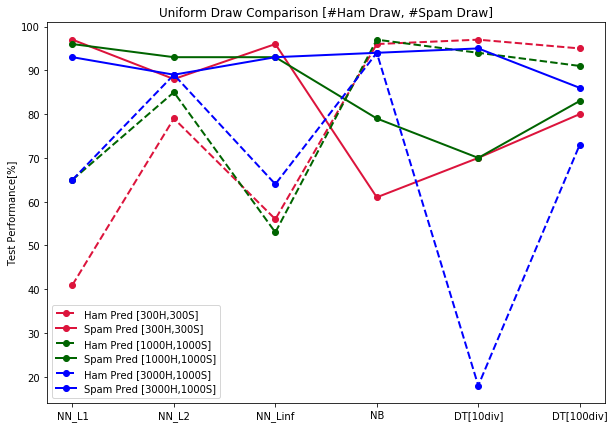

In [403]:
plt.figure(figsize=(10,7))
plt.plot(resulth300_s300[::2], 'o--', color='crimson', lw=2,label='Ham Pred [300H,300S]')
plt.plot(resulth300_s300[1::2], 'o-', color='crimson', lw=2,label='Spam Pred [300H,300S]')
plt.xticks(range(len(index)), index)
plt.plot(resulth1000_s1000[::2], 'o--', color='darkgreen', lw=2,label='Ham Pred [1000H,1000S]')
plt.plot(resulth1000_s1000[1::2], 'o-', color='darkgreen', lw=2,label='Spam Pred [1000H,1000S]')
plt.plot(resulth3000_s1000[::2], 'o--', color='blue', lw=2,label='Ham Pred [3000H,1000S]')
plt.plot(resulth3000_s1000[1::2], 'o-', color='blue', lw=2,label='Spam Pred [3000H,1000S]')

#plt.plot(result_index, resulth3000_s1000, 'o-')
plt.ylabel('Test Performance[%]')
plt.legend()
plt.title('Uniform Draw Comparison [#Ham Draw, #Spam Draw]')
#plt.savefig(file_loc+'uniform_draw.png')

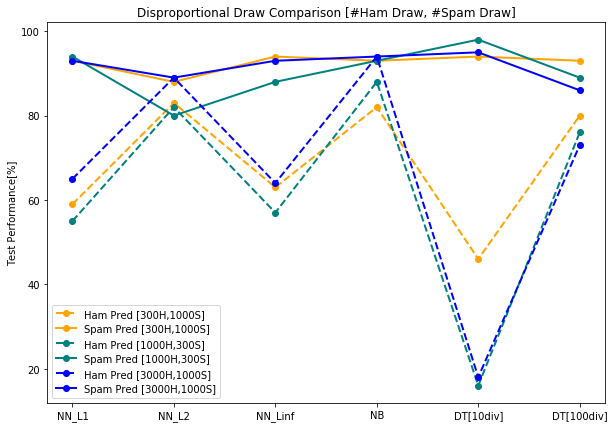

In [410]:
plt.figure(figsize=(10,7))
plt.plot(resulth300_s1000[::2], 'o--', color='orange', lw=2,label='Ham Pred [300H,1000S]')
plt.plot(resulth300_s1000[1::2], 'o-', color='orange', lw=2,label='Spam Pred [300H,1000S]')
plt.xticks(range(len(index)), index)
plt.plot(resulth1000_s300[::2], 'o--', color='teal', lw=2,label='Ham Pred [1000H,300S]')
plt.plot(resulth1000_s300[1::2], 'o-', color='teal', lw=2,label='Spam Pred [1000H,300S]')
plt.plot(resulth3000_s1000[::2], 'o--', color='blue', lw=2,label='Ham Pred [3000H,1000S]')
plt.plot(resulth3000_s1000[1::2], 'o-', color='blue', lw=2,label='Spam Pred [3000H,1000S]')

#plt.plot(result_index, resulth3000_s1000, 'o-')
plt.ylabel('Test Performance[%]')
plt.legend()
plt.title('Disproportional Draw Comparison [#Ham Draw, #Spam Draw]')
plt.savefig(file_loc+'disproportional_draw.png')